# Solar sail (maximum orbit change)

Maximize the dispacement of the solar sail in the tangent manifold of its orbital elements over one orbit:

$$ \delta I' = \mathbf{G}(I,M) \, u,\quad u(M) \in U, $$

$$ \delta I(0) = 0, \quad \delta I(2\pi) \parallel \mathbf{d}, $$

$$ \left( \delta I (2\pi) \, | \, \mathbf{d} \right) \longrightarrow \max. $$

Fixed initial Keplerian orbit and direction of the displacement $\mathbf{d}$. 

[Thumbnail](solarsail.jpg)

## Initializations

In [51]:
import numpy as np
import scipy
from scipy.integrate import ode
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
import time
from nutopy import nle
from nutopy import tools
from nutopy import ocp
from nutopy import path
from scipy.linalg import null_space
from gve import *
from gvef import *
from os import system

# Definition of optical parameters 
rho     = 0.88         # Specular reflection coefficient
a       = 1. - rho    # Absorption coefficient
s       = 0.94        # Diffuse reflection coefficient 
eps_f   = 0.05        # Emissivity front coeff 0.05
eps_b   = 0.55        # Emissivity back coeff 0.55
Bf      = 0.79        # Front Lambertian coeff 0.79
Bb      = 0.55        # Back Lambertian coeff 0.55
eps     = (Bf * eps_f - Bb * eps_b) / (eps_b + eps_f) 
#opt_p   = np.array([rho, s, eps_f, eps_b, Bf, Bb, eps])
b       = np.array([1. - rho * s, 2. * rho * s, Bf * rho * (1. - s) + (1. - rho) * eps ])

# Parameters of the problem
cont    = 0. # 0 for triangular cone, 1 for real drop 
mu      = 1.


def deg2rad(x):
    y = x * np.pi / 180.
    return y

def rad2deg(x):
    y = x * 180. / np.pi
    return y

# CASE WITH STRUCTURE CHANGE

I            = np.array([deg2rad(10), deg2rad(50), deg2rad(30), 1, 0.1]) 
pdeltaI           = np.array([ -0.0837,    1.0000,   -0.0052,    0.0398,    0.0852 ])
M1_guess     = 0.7086
M2_guess     = 4.3302
M3_guess     = 4.7962
M4_guess     = 5.2500
deltaI1_guess     = np.array([ -0.0013,   -0.0002,    0.0251,    0.0027,    0.0012])
deltaI2_guess     = np.array([ 0.0136,    0.4053,   -0.3069,    0.0473,   0.0656])
deltaI3_guess     = np.array([ 0.0148,    0.4054,   -0.3289,    0.0498,    0.0626])
deltaI4_guess     = np.array([ 0.0000,    0.4134,   -0.0002,    0.0001,    0.0000])
d            = np.array([ 0.,  1.,  0.,  0.,  0.]) 

z         = np.hstack((pdeltaI, M1_guess, M2_guess, M3_guess, M4_guess, deltaI1_guess, deltaI2_guess, deltaI3_guess, deltaI4_guess))

sDir       = np.array([0., 0., -1.])

# Initial state

deltaI0      = np.array([0., 0., 0., 0., 0]) # delta I (0)
M0      = 0
Mf      = 2*np.pi

# Real cone force definition
cBeta   = (- b[0] * b[2]  - 2. * b[1] * b[2] + \
             np.sqrt(b[0] ** 2 * b[2] ** 2 - 4. * b[0] * b[2] ** 2 * b[1] + 8. * b[0] ** 2 * b[1] ** 2 + 4. * b[1] ** 3 * b[0])) / \
             (4. * b[0] * b[1] + 2. * b[1] ** 2);
sBeta 	= np.sqrt(1 - cBeta ** 2);
fs    	= b[0] * cBeta + (b[1] * cBeta ** 2 + b[2] * cBeta) * cBeta;
fperp 	= (b[1] * cBeta ** 2 + b[2] * cBeta) * sBeta;
fCone 	= np.array([fs, fperp])


pars    = np.hstack((mu, I, fCone, b))
# Orthogonal vector family
d_orth  = scipy.linalg.null_space([d])                                                                     # Orthogonal space of b
d_orth  = d_orth.transpose()

In [52]:
#!pygmentize hfun.f90			

## Hamiltonian

In [53]:
!python -m numpy.f2py -c hfun.f90      -m hfun     > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d.f90    -m hfun_d   > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d_d.f90  -m hfun_d_d > /dev/null 2>&1
!python -m numpy.f2py -c hfunalpha_da.f90 -m hfunalpha_da > /dev/null 2>&1

In [54]:
from hfun     import hfun   
from hfun_d   import hfun_d   
from hfun_d_d import hfun_d_d 
from hfunalpha_da import hfunalpha_da as dhfunalpha

hfun_u      = lambda M, q, p, pars, cont                                           : hfun.hfun_u(M, q, p, pars, cont)
ufun        = lambda M, q, p, cont                                                 : hfun.control(M, q, p, pars, cont) 
pmpcone     = lambda pIG, sDir, fcone                                              : hfun.pmpcone(pIG, sDir, fcone)
pmpsail     = lambda pIG, sDir, b                                                  : hfun.pmpsail(pIG, sDir, b)
theta2alpha = lambda theta, b                                                      : hfun.theta2alpha(theta, b) 
gveeci      = lambda M, I, mu                                                      : hfun.gveeci(M, I, mu) 
dhfun_u     = lambda M, dM, q, dq, p, dp, pars, cont, dcont                        : hfun_d.hfun_u_d(M, dM, q, dq, p, dp, pars, cont, dcont)
d2hfun_u    = lambda M, dM, d2M, q, dq, d2q, p, dp, d2p, pars, cont, dcont, d2cont : hfun_d_d.hfun_u_d_d(M, dM, d2M, q, dq, d2q, p, dp, d2p, pars, cont, dcont, d2cont)

In [55]:
def dhfun_0(M, dM, q, dq, p, dp, pars, cont, dcont):
    h = 0.0
    dh  = 0.0
    return h, dh

def d2hfun_0(M, dM, d2M, q, dq, d2q, p, dp, d2p, pars, cont, dcont, d2cont):
    h   = 0.0
    dh  = 0.0
    d2h = 0.0
    return h, dh, d2h

def hfun_0(M, q, p, pars, cont):
    h = 0.0
    return h

In [56]:
hfun_u      = tools.tensorize(dhfun_u, d2hfun_u, tvars=(1, 2, 3, 5), full=True)(hfun_u)
hfun_0      = tools.tensorize(dhfun_0, d2hfun_0, tvars=(1, 2, 3, 5), full=True)(hfun_0)
ufun        = tools.vectorize(vvars=(1,2,3))(ufun)
Hu          = ocp.Hamiltonian(hfun_u)
H0          = ocp.Hamiltonian(hfun_0)
fu          = ocp.Flow(Hu)
f0          = ocp.Flow(H0)

## Auxialiary functions

In [57]:
def calculpIG(M, I, pdeltaI) :
    [fx, fy, fz] = gveeci(M, I, mu)
    pIG = np.array([0.0, 0.0, 0.0])
    pIG[0] = np.dot(fx[0:5],pdeltaI)
    pIG[1] = np.dot(fy[0:5],pdeltaI)
    pIG[2] = np.dot(fz[0:5],pdeltaI)
    return pIG

In [58]:
def f_aux(M, I, pdeltaI):
    pIG = calculpIG(M, I, pdeltaI)
    theta = np.arccos(np.dot(pIG,sDir)/np.linalg.norm(pIG))
    alpha = theta2alpha(theta, b)
    return alpha

## function that calculates the number of switches

In [59]:
## GEOMETRIC POLYNOMIAL calculates: v1^2 + v^2 - c^2 * v^3 (= 0?) 

def switch_pol_geom_gve(z, pars, f):
    #rho = opt_p[0]; s = opt_p[1]; eps_f = opt_p[2]; eps_b = opt_p[3]; Bf = opt_p[4]; Bb = opt_p[5]; eps = opt_p[6]
    Om = pars[1]; i = pars[2]; w = pars[3]; a = pars[4]; e = pars[5]
    pI = z[0 : 5]
    mu = pars[0]	
    
    # COMPUTATION OF ANGLE ALPHA
    alpha      = np.arctan2(fperp, fs)
    c          = np.tan(alpha + np.pi/2)
    cosf       = np.cos(f)    
    coef2      = (1. + e * cosf)**2

    OE         = np.array([Om, i, w, a, e, f])
    Fx, Fy, Fz = gveecif(OE, mu)
    v1         = pI[0] * Fx[0] +  pI[1] * Fx[1] + pI[2] * Fx[2] + pI[3] * Fx[3] + pI[4] * Fx[4]
    v2         = pI[0] * Fy[0] +  pI[1] * Fy[1] + pI[2] * Fy[2] + pI[3] * Fy[3] + pI[4] * Fy[4]
    v3         = pI[0] * Fz[0] +  pI[1] * Fz[1] + pI[2] * Fz[2] + pI[3] * Fz[3] + pI[4] * Fz[4]
    
    sol        = v1 ** 2 * coef2 + v2**2 * coef2 - c**2 * v3**2 * coef2
    return sol


## ROOTS RESEARCH FOR A FOURIER SERIE (when = 0) UP TO DEG 4
@tools.vectorize(vvars =(1,))
def switch_fun(z, pars):
    
    Om = pars[1]; i = pars[2]; w = pars[3]; a = pars[4]; e = pars[5]
    pI = z[0 : 5]
    mu = pars[0]	
    
    N_fft    = 13
    f_vect   = np.linspace(0, 2 * np.pi, N_fft+1)
    
    y = find_Fourier_gve(z, pars, N_fft)
    
    # Coefficients of a trigonometric polynomial
    a0     = y[0]
    a1     = y[1] + y[N_fft-1]
    a2     = y[2] + y[N_fft-2]
    a3     = y[3] + y[N_fft-3]
    a4     = y[4] + y[N_fft-4]
    b1     = 1j * (y[1] - y[N_fft-1])
    b2     = 1j * (y[2] - y[N_fft-2])
    b3     = 1j * (y[3] - y[N_fft-3])
    b4     = 1j * (y[4] - y[N_fft-4])
    
    # Construction of a Fourier - Frobenius matrix
    B81    = - (a4 + b4 * 1j) / (a4 - b4 * 1j)
    B82    = - (a3 + b3 * 1j) / (a4 - b4 * 1j)
    B83    = - (a2 + b2 * 1j) / (a4 - b4 * 1j)
    B84    = - (a1 + b1 * 1j) / (a4 - b4 * 1j)
    B85    = - (2 * a0) / (a4 - b4 * 1j)
    B86    = - (a1 - b1 * 1j) / (a4 - b4 * 1j)
    B87    = - (a2 - b2 * 1j) / (a4 - b4 * 1j)
    B88    = - (a3 - b3 * 1j) / (a4 - b4 * 1j)
    
    B      = np.array([[0, 1, 0, 0, 0, 0, 0, 0],
                       [0, 0, 1, 0, 0, 0, 0, 0],
                       [0, 0, 0, 1, 0, 0, 0, 0],
                       [0, 0, 0, 0, 1, 0, 0, 0],
                       [0 ,0 ,0 ,0, 0, 1, 0, 0],
                       [0 ,0 ,0 ,0, 0, 0, 1, 0],
                       [0 ,0 ,0 ,0, 0, 0, 0, 1],
                       [B81, B82, B83, B84, B85, B86, B87, B88]])
   
    eig_val        = np.linalg.eig(B)[0]
    eig_real       = []
    
    tol            = 10**(-10)
    
    for ii, val in enumerate(eig_val):
        if np.abs(val) < 1 + tol and np.abs(val) > 1 - tol:
            eig_real = np.hstack((eig_real, val))
        
    sol_all      = np.angle(eig_real)
    #sol_complex    = -1j * np.log(np.abs(eig_val)) + np.angle(eig_val)
    #sol_angles     = np.angle(eig_val)
    
    for ii, val in enumerate(sol_all):
        if val < 0:
            sol_all[ii] = sol_all[ii] + 2*np.pi
            
            
    sol_angles = []  
    # Solutions that satisfy v3 >= 0:
    
    for ii, val in enumerate(sol_all):
        f = val
        cosf       = np.cos(f)    
        coef2      = (1. + e * cosf)**2

        OE         = np.array([Om, i, w, a, e, f])
        Fx, Fy, Fz = gveecif(OE, mu)
        
        v3         = pI[0] * Fz[0] +  pI[1] * Fz[1] + pI[2] * Fz[2] + pI[3] * Fz[3] + pI[4] * Fz[4]
        
        if v3 >= 0:
            sol_angles = np.hstack((sol_angles, val))
    
    return sol_angles, sol_all



def find_Fourier_gve(z, pars, N_fft):
    f_vect   = np.linspace(0, 2 * np.pi, N_fft+1)
    sw       = np.zeros(N_fft)
    for ii in range(N_fft):
        sw[ii] = switch_pol_geom_gve(z, pars, f_vect[ii])
    
    y = scipy.fft.fft(sw) / N_fft
    return y



## FOURIER SERIE VERIFICATION (up to deg 4)
def pol_Fourier(y,f, N_fft):
    #res = scipy.fft.ifft(y)
    res = y[0] * np.exp(1j * 0 * f) + y[1] * np.exp(1j * 1 * f) + y[N_fft-1] * np.exp(1j * (-1) * f) \
                +  y[2] * np.exp(1j * 2 * f) + y[N_fft-2] * np.exp(1j * (-2) * f) \
                +  y[3] * np.exp(1j * 3 * f) + y[N_fft-3] * np.exp(1j * (-3) * f) \
                +  y[4] * np.exp(1j * 4 * f) + y[N_fft-4] * np.exp(1j * (-4) * f) 
    return res 


In [60]:
sol_switches, sol_all = switch_fun(z, pars)
#sol_switches, nb_switches, sol_all = switch_fun(z, pars)
sol_switches.sort()
nb_switches = np.size(sol_switches)

## Shooting method with a change of structure 

In [61]:
#Initial condition 

deltaI0   = np.zeros(5)
M0        = 0.
Mf        = 2. * np.pi 

In [62]:
#@tools.tensorize(dshoot, tvars=(1,), full=True)
def shoot(z, pars, d, d_orth, cont, nb_switches):
    
    #Initializations
    
    pdeltaI   = z[0 : 5]
    M      = np.zeros((nb_switches + 2))
    deltaI = np.array([])
    size = nb_switches
        
    M[0] = M0
    for i in range(0, size) :
        M[i+1] =  z[5+i]
        deltaI = np.hstack((deltaI, z[5 * (i+1) + size : 5 * (i+2) + size]))
    M[-1] = Mf

    deltaIsol = np.zeros(((size + 1) * 5))
    pdeltaIsol = np.zeros(((size + 1) * 5))
    
    #---------------------------------------------------------------------
    
    #Numerical integration
    
    #---------------------------------------------------------------------
    
    #To calculate hcone
    pIG = calculpIG(M0, pars[1:6], pdeltaI)
    ucone = pmpcone(pIG, sDir, pars[7:9])
    hcone = np.dot(pIG, ucone)
    
    #---------------------------------------------------------------------
    
    if(hcone <= 0) :
        deltaIsol[0 : 5], pdeltaIsol[0 : 5] = f0(M[0], deltaI0, pdeltaI, M[1], pars, cont)
        bool = True
    else :
        deltaIsol[0 : 5], pdeltaIsol[0 : 5] = fu(M[0], deltaI0, pdeltaI, M[1], pars, cont)
        bool = False
    
    for i in range(1, size + 1) : 
        if(bool == True) :
            deltaIsol[5*i : 5*(i+1)], pdeltaIsol[5*i : 5*(i+1)] = fu(M[i], deltaI[5*(i-1) : 5*i], pdeltaI, M[i+1], pars, cont)
            bool = False
        else :
            deltaIsol[5*i : 5*(i+1)], pdeltaIsol[5*i : 5*(i+1)] = f0(M[i], deltaI[5*(i-1) : 5*i], pdeltaI, M[i+1], pars, cont)
            bool = True
            
    #---------------------------------------------------------------------
    
    #Definition of s
    
    #---------------------------------------------------------------------
        
    length     = np.size(deltaIsol)
    pf         = pdeltaIsol[ length - 5 : length ]
    
    s          = np.zeros((size + 1) * 5 + size)
    s[0]       = pf[0] * d[0] + pf[1] * d[1] + pf[2] * d[2] + pf[3] * d[3] + pf[4] * d[4] - np.linalg.norm(d)**2
    s[1 : 5]   = np.dot(d_orth, deltaIsol[length - 5 : length])

    
    for i in range(1, size + 1) :
        s[5 + (i-1)]        = Hu(M[i], deltaI[5*(i-1) : 5*i], pdeltaI, pars, cont)
        s[size + 5 * i  : 5 * (i+1) + size]   = deltaI[5*(i-1) : 5*i] - deltaIsol[5*(i-1) : 5*i] 

    return s

In [63]:
@tools.vectorize(vvars =(1,))
def control(M, I, pdeltaI, cont):
    
    sol  = np.array([0., 0., 0.])
    if type(M)==float or type(M)==int:
        #Calcul of hcone
        pIG = calculpIG(M, I, pdeltaI)
        ucone = pmpcone(pIG, sDir, pars[7:9])
        hcone = np.dot(pIG, ucone)
        
        if hcone < 0.:
            sol = np.array([0., 0., 0.])
        else: 
            sol = ufun(M, I, pdeltaI, cont)
    else:
        for ii in range(len(M)):
            #Calcul of hcone
            pIG = calculpIG(M[ii], I, pdeltaI)
            ucone = pmpcone(pIG, sDir, pars[7:9])
            hcone = np.dot(pIG, ucone)
            
            if hcone < 0.:
                sol = np.vstack((sol, np.array([0., 0., 0.])))
            else: 
                sol = np.vstack((sol, ufun(M[ii], I, pdeltaI, cont)))   
        sol = np.delete(sol, 0, 0)
    return sol

## Callback

In [64]:
def check_singular_arc(infos):
    t = np.array([])
    
    for i in range(nb_switches) : 
        t = np.hstack((t, infos.x[i+5]))
        
    status = 0
    for j in range(0,len(t)) :
        for k in range(j+1, len(t)) :
            if (t[k] < t[j]) :
                status = -11 # the singular arc has vanished
                
        for l in range(0, j) :
            if (t[l] > t[j]) :
                status = -11
                
    return status

## Solve

In [65]:
foo = lambda z, cont: shoot(z, pars, d, d_orth, cont, nb_switches)

In [66]:
nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8) 

opt      = path.Options(ODESolver = "dopri5");
sol = path.solve(foo, z, 0., 1., callback = check_singular_arc, options = opt)

#sol = nle.solve(foo, z, options=nleopt, args=cont)
        
while (sol.success == False) :
    t       = np.array([])
    newz    = np.array(sol.xf[0 : 5])
    keepind = np.array([])
    compt   = 0
    
    for i in range(nb_switches) : 
        t = np.hstack((t, sol.xf[i+5]))
    
    #We are looking at a change of structure
    for j in range(0,len(t)) :
        bool = True
        for k in range(j+1, len(t)) :
            if (t[k] < t[j]) :
                bool = False
                
        for l in range(0, j) :
            if (t[l] > t[j]) :
                bool = False
                
        if (bool == True) :
            compt  += 1
            keepind = np.hstack((keepind, j))
            newz    = np.hstack((newz, t[j]))  
    
    for i in range(len(keepind)) :
        newz = np.hstack((newz, sol.xf[int(len(t) + (keepind[i] + 1) * 5) : int(len(t) + (keepind[i] + 2) * 5) ]))
    
    #We save the new structure
    nb_switches  = compt  
    
    #We keep the solutions of the first homotopy for the gif
    allfirstsols = sol.xout
    firstpars    = sol.parsout
    
    #We recall the homotopy 
    opt      = path.Options(ODESolver = "dopri5");
    sol      = path.solve(foo, newz, sol.parsf, 1., callback = check_singular_arc, options = opt)

et = time.time(); 
        
et = time.time() - et
print('Elapsed time:', et)

final_z_sol = sol.xf; 

allfinalsols = sol.xout
finalpars = sol.parsout

print('z_sol =', final_z_sol)
print('foo =', foo(final_z_sol, cont))


     Calls  |f(x)|                 |x|
 
         1  3.000290257575716e-01  8.458754036499702e+00
         2  2.463904514101377e-02  8.441471347904109e+00
         3  1.549946542833690e-02  8.459145060626348e+00
         4  1.120337517813491e-03  8.456733309871549e+00
         5  3.467671004800750e-04  8.457261581742065e+00
         6  6.962366717872526e-04  8.456359512950666e+00
         7  1.493966047255819e-04  8.455995147104664e+00
         8  1.911705326523057e-05  8.455700779322248e+00
         9  7.637012438598071e-06  8.455549027719654e+00
        10  8.485871765301826e-07  8.455563545866237e+00
        11  5.268180858097550e-08  8.455564550947164e+00
        12  6.055761977234371e-09  8.455564676569672e+00
        13  3.191876308801750e-10  8.455564668687746e+00

 Results of the nle solver method:

 xsol    =  [-9.68686040e-02  1.00000000e+00 -6.32529421e-03  2.76163955e-02
  9.67591726e-02  7.33844044e-01  4.27804559e+00  4.94753160e+00
  5.14590229e+00  5.12567243e-27  2.02

AttributeError: 'NLESol' object has no attribute 'xf'

In [67]:
pdeltaI = final_z_sol[0 : 5]
M = np.array([])
deltaI = np.array([])
size = nb_switches

for i in range(0, size) :
    M = np.hstack((M, final_z_sol[i+5]))
    deltaI  = np.hstack((deltaI, final_z_sol[5 * (i+1) + size : 5 * (i+2) + size]))

u = control(M0, deltaI0, pdeltaI, cont)


## Plot function

In [68]:
def plotSolutionBSB(pdeltaI, M, sDir, cont, nOrb):
    
    #Initializations
    #----------------------------------------- 
    
    N       = 500
    size    = np.size(M) - 2 
    
    M_vect  = np.array([])
    g1      = np.array([])
    g2      = np.array([])
    g3      = np.array([])
    a       = np.array([])
    e       = np.array([])
    dvect   = np.array([])
    M0_2_Mf = np.array([])
    
    qd = np.zeros(5)
    pd = np.zeros(5)
    
    deltaIsol  = [0] * (size + 1)
    pdeltaIsol = [0] * (size + 1)
    
    u_vect  = np.array([0., 0., 0.])
    I       = np.array([0., 0., 0., 0., 0]) 
    deltaI0      = np.array([0., 0., 0., 0., 0]) 
    M0      = M[0]
    
    #----------------------------------------- 
    
    for i in range(0, size + 1) :
        M0_2_Mf = np.hstack((M0_2_Mf, np.linspace(M[i], M[i+1], N+1)))
        
    for ii in range(nOrb):
        
        Mspan   = []
        
        for i in range(0, size + 1) : 
            Mspan.append(list((ii)*2*np.pi*np.ones(N+1)+M0_2_Mf[i*(N+1) : (i+1)*(N+1)]))
        
        #Calcul of hcone 
        pIG = calculpIG(M0, pars[1:6], pdeltaI)
        ucone = pmpcone(pIG, sDir, pars[7:9])
        hcone = np.dot(pIG, ucone)
        
        #Numerical integration
        #------------------------------------------------------------------------------------------------------------
        
        if(hcone <= 0) :
            deltaIsol[0], pdeltaIsol[0] = f0(M0, deltaI0, pdeltaI, Mspan[0], pars, cont)
            bool = True
        else :
            deltaIsol[0], pdeltaIsol[0] = fu(M0, deltaI0, pdeltaI, Mspan[0], pars, cont)
            bool = False
  
        for i in range(1, size + 1) : 
            if(bool == True) :
                deltaIsol[i], pdeltaIsol[i] = fu(Mspan[i-1][-1], deltaIsol[i-1][-1], pdeltaI, Mspan[i], pars, cont)
                bool = False
            else :
                deltaIsol[i], pdeltaIsol[i] = f0(Mspan[i-1][-1], deltaIsol[i-1][-1], pdeltaI, Mspan[i], pars, cont)
                bool = True
                
        #------------------------------------------------------------------------------------------------------------
                
        for i in range(0,size + 1) :
            M_vect        = np.hstack((M_vect, Mspan[i]))

        for j in range(0, size + 1) :
            for kk in range(N+1):
                val           = deltaIsol[j][kk]
                g1            = np.hstack((g1, val[0]))
                g2            = np.hstack((g2, val[1]))
                g3            = np.hstack((g3, val[2]))
                a             = np.hstack((a, val[3]))
                e             = np.hstack((e, val[4]))
                
                alpha         = f_aux(Mspan[j][kk], pars[1:6], pdeltaIsol[j][kk])
   
                if(Hu(Mspan[j][kk], deltaIsol[j][kk], pdeltaI, pars, cont) >= 0) :
                    dvect         = np.hstack((dvect, dhfunalpha(Mspan[j][kk], 0.0, deltaIsol[j][kk], qd, pdeltaI, pd, alpha, 1.0, pars, cont)[1]))
                else : 
                    dvect         = np.hstack((dvect,0.0))

            
        deltaI0     = deltaIsol[-1][-1]
        M0          = Mspan[-1][-1]
 
    #Calcul of the cone and the clock angle
    #-------------------------------------------------
    
    u_vect = control(M_vect, I, pdeltaI, cont)
    u_s    = np.dot(u_vect,sDir)
    u_1    = u_vect[:,0]
    u_2    = u_vect[:,1]
    u_3    = u_vect[:,2]

    norm   = np.linalg.norm(u_vect,axis=1)
    ang1   = np.arccos(u_s/norm)
    where_are_NaNs = np.isnan(ang1)
    ang1[where_are_NaNs] = 0
    ang1   = rad2deg(ang1)
    
    ang2   = np.arctan2(u_2 / norm , u_1 / norm)
    where_are_NaNs = np.isnan(ang2)
    ang2[where_are_NaNs] = 0
    ang2   = rad2deg(ang2)
    
    #-------------------------------------------------

    #Plots
    #-------------------------------------------------------------------------------------------------
    
    M_vect = M_vect / 2 / np.pi * 360
    fig = plt.figure(); plt.tight_layout()
    ax1  = fig.add_subplot(421); 
    ax1.plot(M_vect, g1); 
    ax2  = fig.add_subplot(422); 
    ax2.plot(M_vect, g2); 
    ax3  = fig.add_subplot(423); 
    ax3.plot(M_vect, g3); 
    ax4  = fig.add_subplot(424); 
    ax4.plot(M_vect, a); 
    ax5  = fig.add_subplot(425); 
    ax5.plot(M_vect, e);
    ax6  = fig.add_subplot(426); 
    ax6.plot(M_vect, ang1, label='cone angle'); 
    ax6.plot(M_vect, ang2, label='clock angle');
    ax7    = fig.add_subplot(427); 
    ax7.plot(M_vect, dvect); 
    
    label_name = 'Satellite longitude [deg]'
    
    ax1.set_xlabel(label_name); ax1.set_ylabel('$\gamma_1 \epsilon^{-1}$'); ax1.axhline(0, color='k')
    ax2.set_xlabel(label_name); ax2.set_ylabel('$\gamma_2 \epsilon^{-1}$'); ax2.axhline(0, color='k')
    ax3.set_xlabel(label_name); ax3.set_ylabel('$\gamma_3 \epsilon^{-1}$'); ax3.axhline(0, color='k')
    ax4.set_xlabel(label_name); ax4.set_ylabel('$a \epsilon^{-1}$');        ax4.axhline(0, color='k')
    ax5.set_xlabel(label_name); ax5.set_ylabel('$e \epsilon^{-1}$');        ax5.axhline(0, color='k')
    ax6.set_xlabel(label_name); ax6.set_ylabel('$Control \ angle $'); 
    ax6.legend()
    ax7.set_xlabel(label_name); ax7.set_ylabel('dh'); 
    plt.savefig('figures/plot.png')
    

## Plots

In [69]:
pdeltaI = final_z_sol[0 : 5]
M       = np.array([])
deltaI  = np.array([])
size    = nb_switches

M = np.hstack((M, M0))
for i in range(0, size) :
    M       = np.hstack((M, final_z_sol[i+5]))
    deltaI  = np.hstack((deltaI, final_z_sol[5 * (i+1) + size : 5 * (i+2) + size]))
M = np.hstack((M, Mf))

print(final_z_sol)


[-9.68686040e-02  1.00000000e+00 -6.32529421e-03  2.76163955e-02
  9.67591726e-02  7.33844044e-01  4.27804559e+00  4.94753160e+00
  5.14590229e+00  5.12567243e-27  2.02083856e-26  3.27503195e-27
  1.66404352e-27  2.74527075e-26  8.17408118e-03  4.34424964e-01
 -2.27297215e-01  3.32189285e-02  3.41222370e-02  8.17408118e-03
  4.34424964e-01 -2.27297215e-01  3.32189285e-02  3.41222370e-02
 -2.42200666e-26  4.39314680e-01  2.17667639e-25  6.58816745e-27
 -4.52361350e-26]


### One orbit

#### Trajectory

/net/home/c/ct705827/.conda/envs/ct-gallery/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
/net/home/c/ct705827/.conda/envs/ct-gallery/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


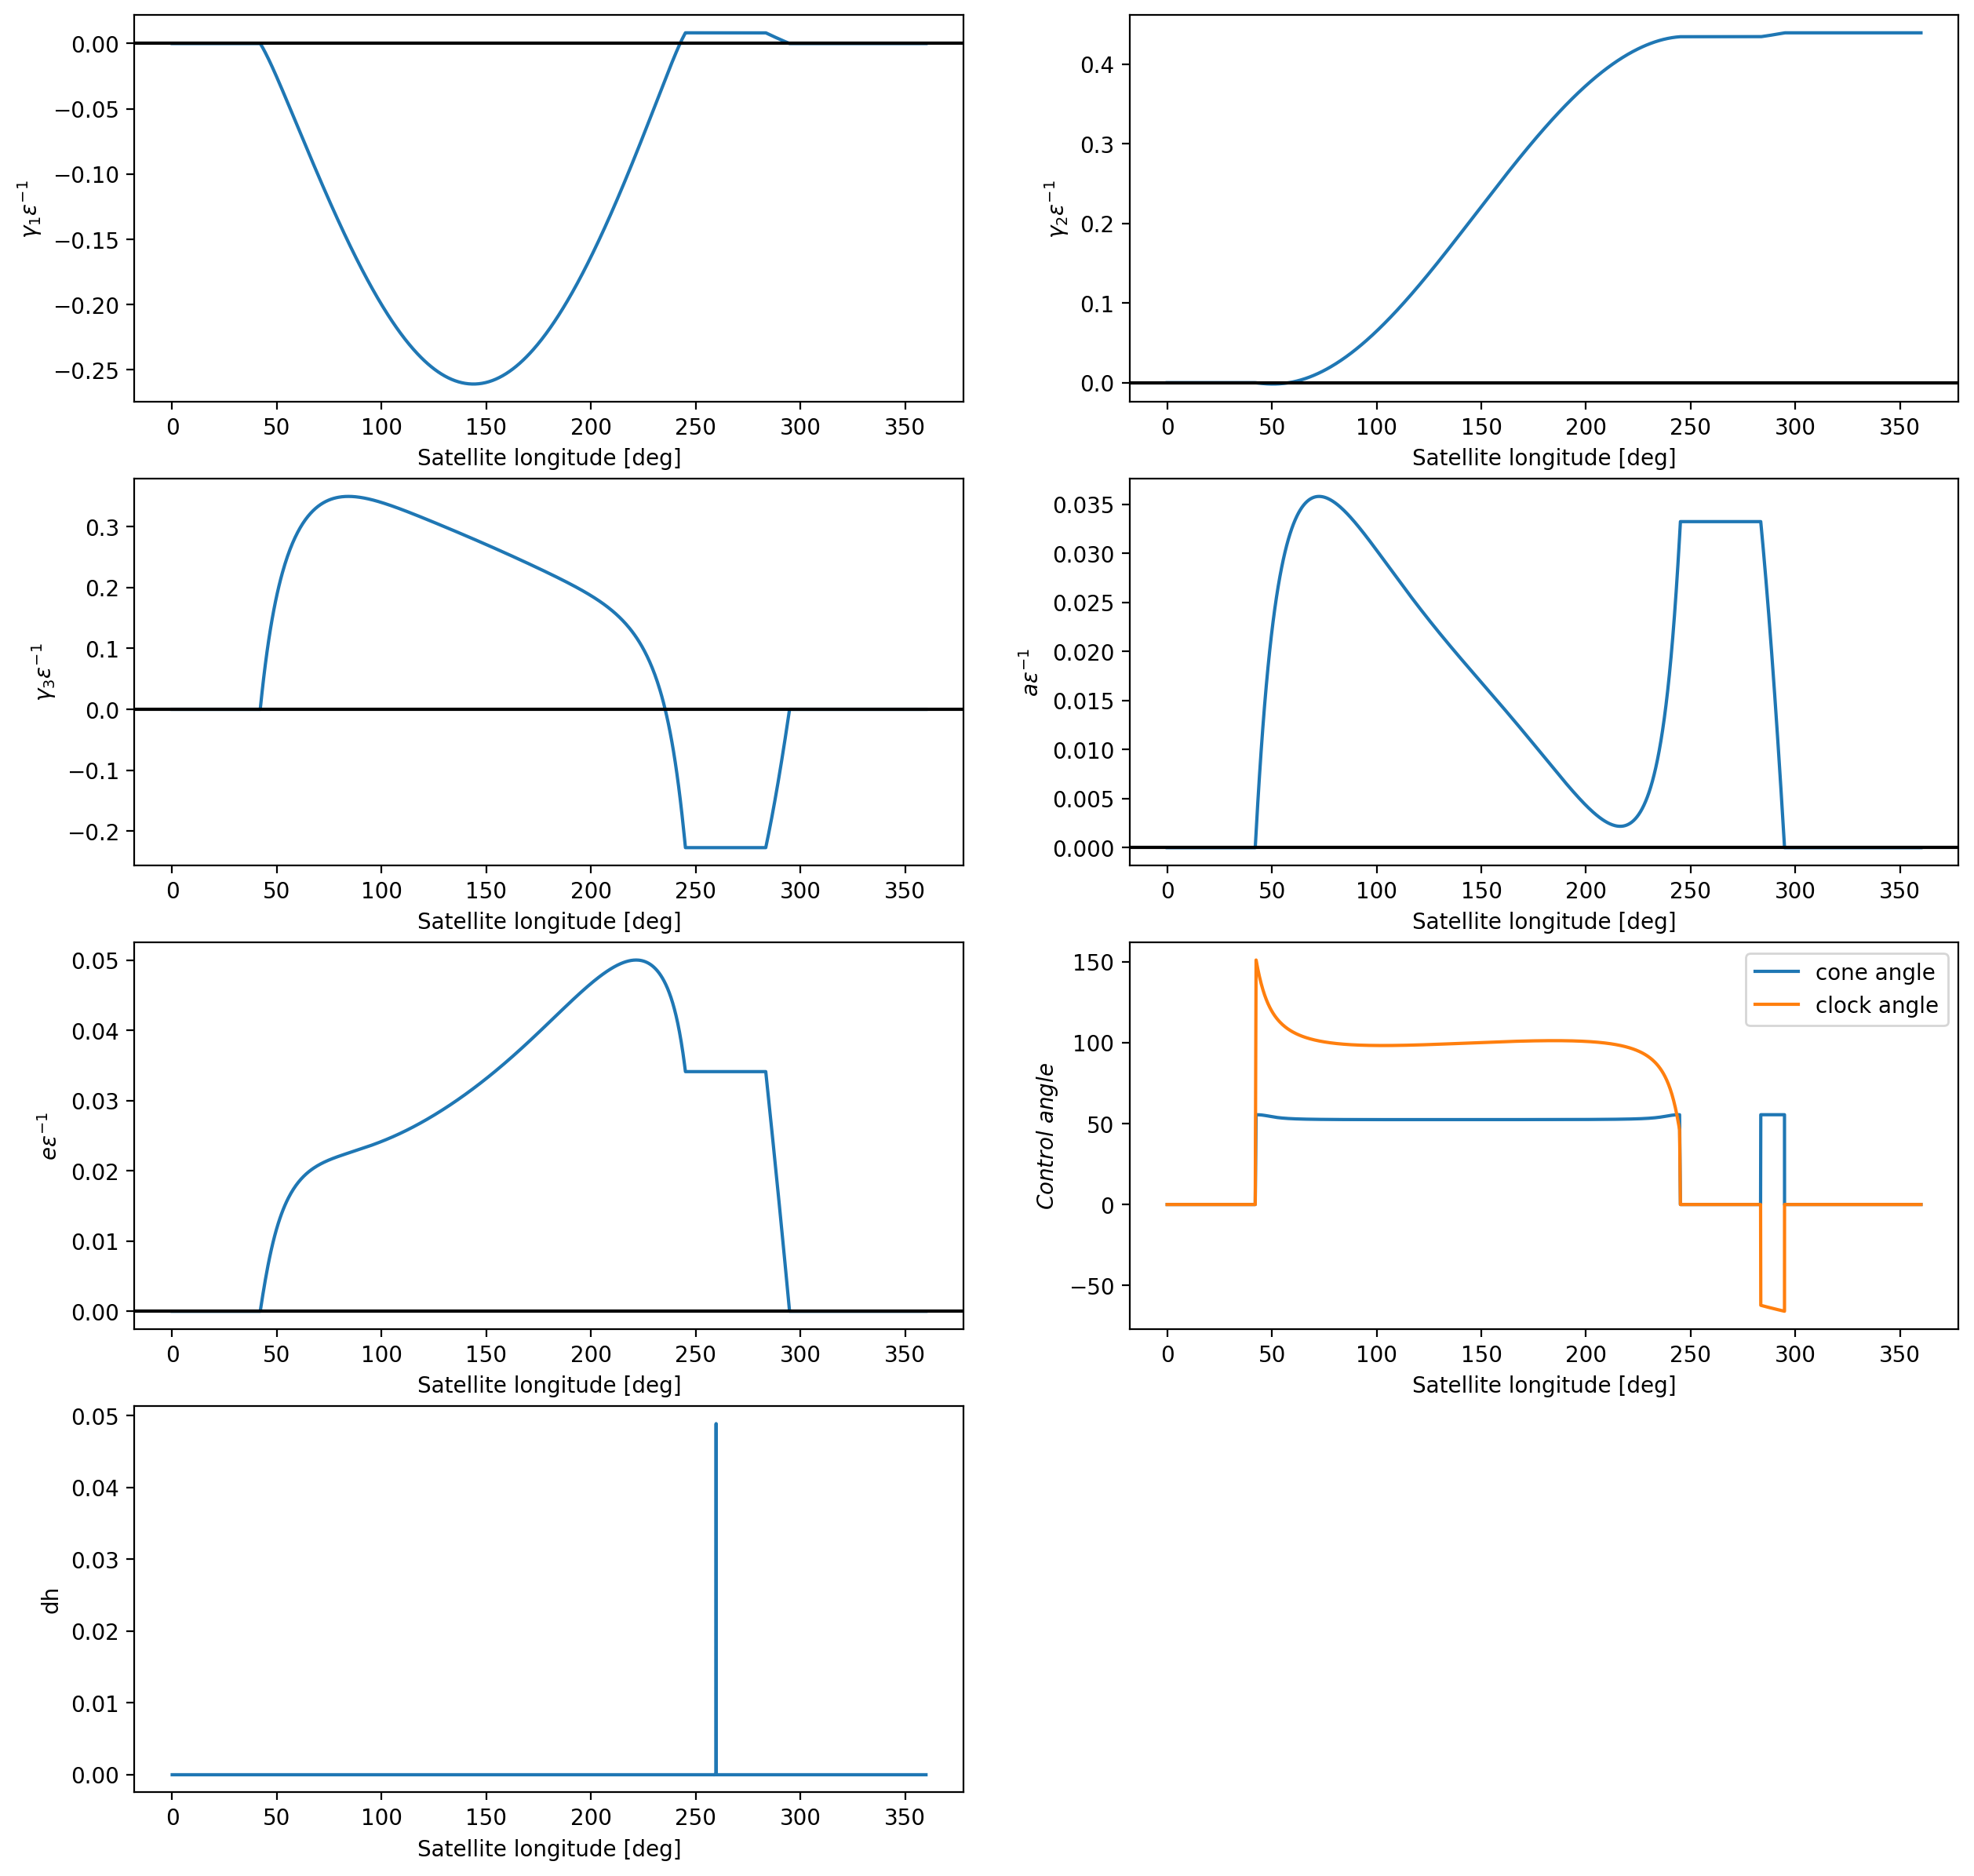

In [70]:
plotSolutionBSB(pdeltaI, M, sDir, sol.parsf, 1)

### Multiple orbits

/net/home/c/ct705827/.conda/envs/ct-gallery/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
/net/home/c/ct705827/.conda/envs/ct-gallery/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


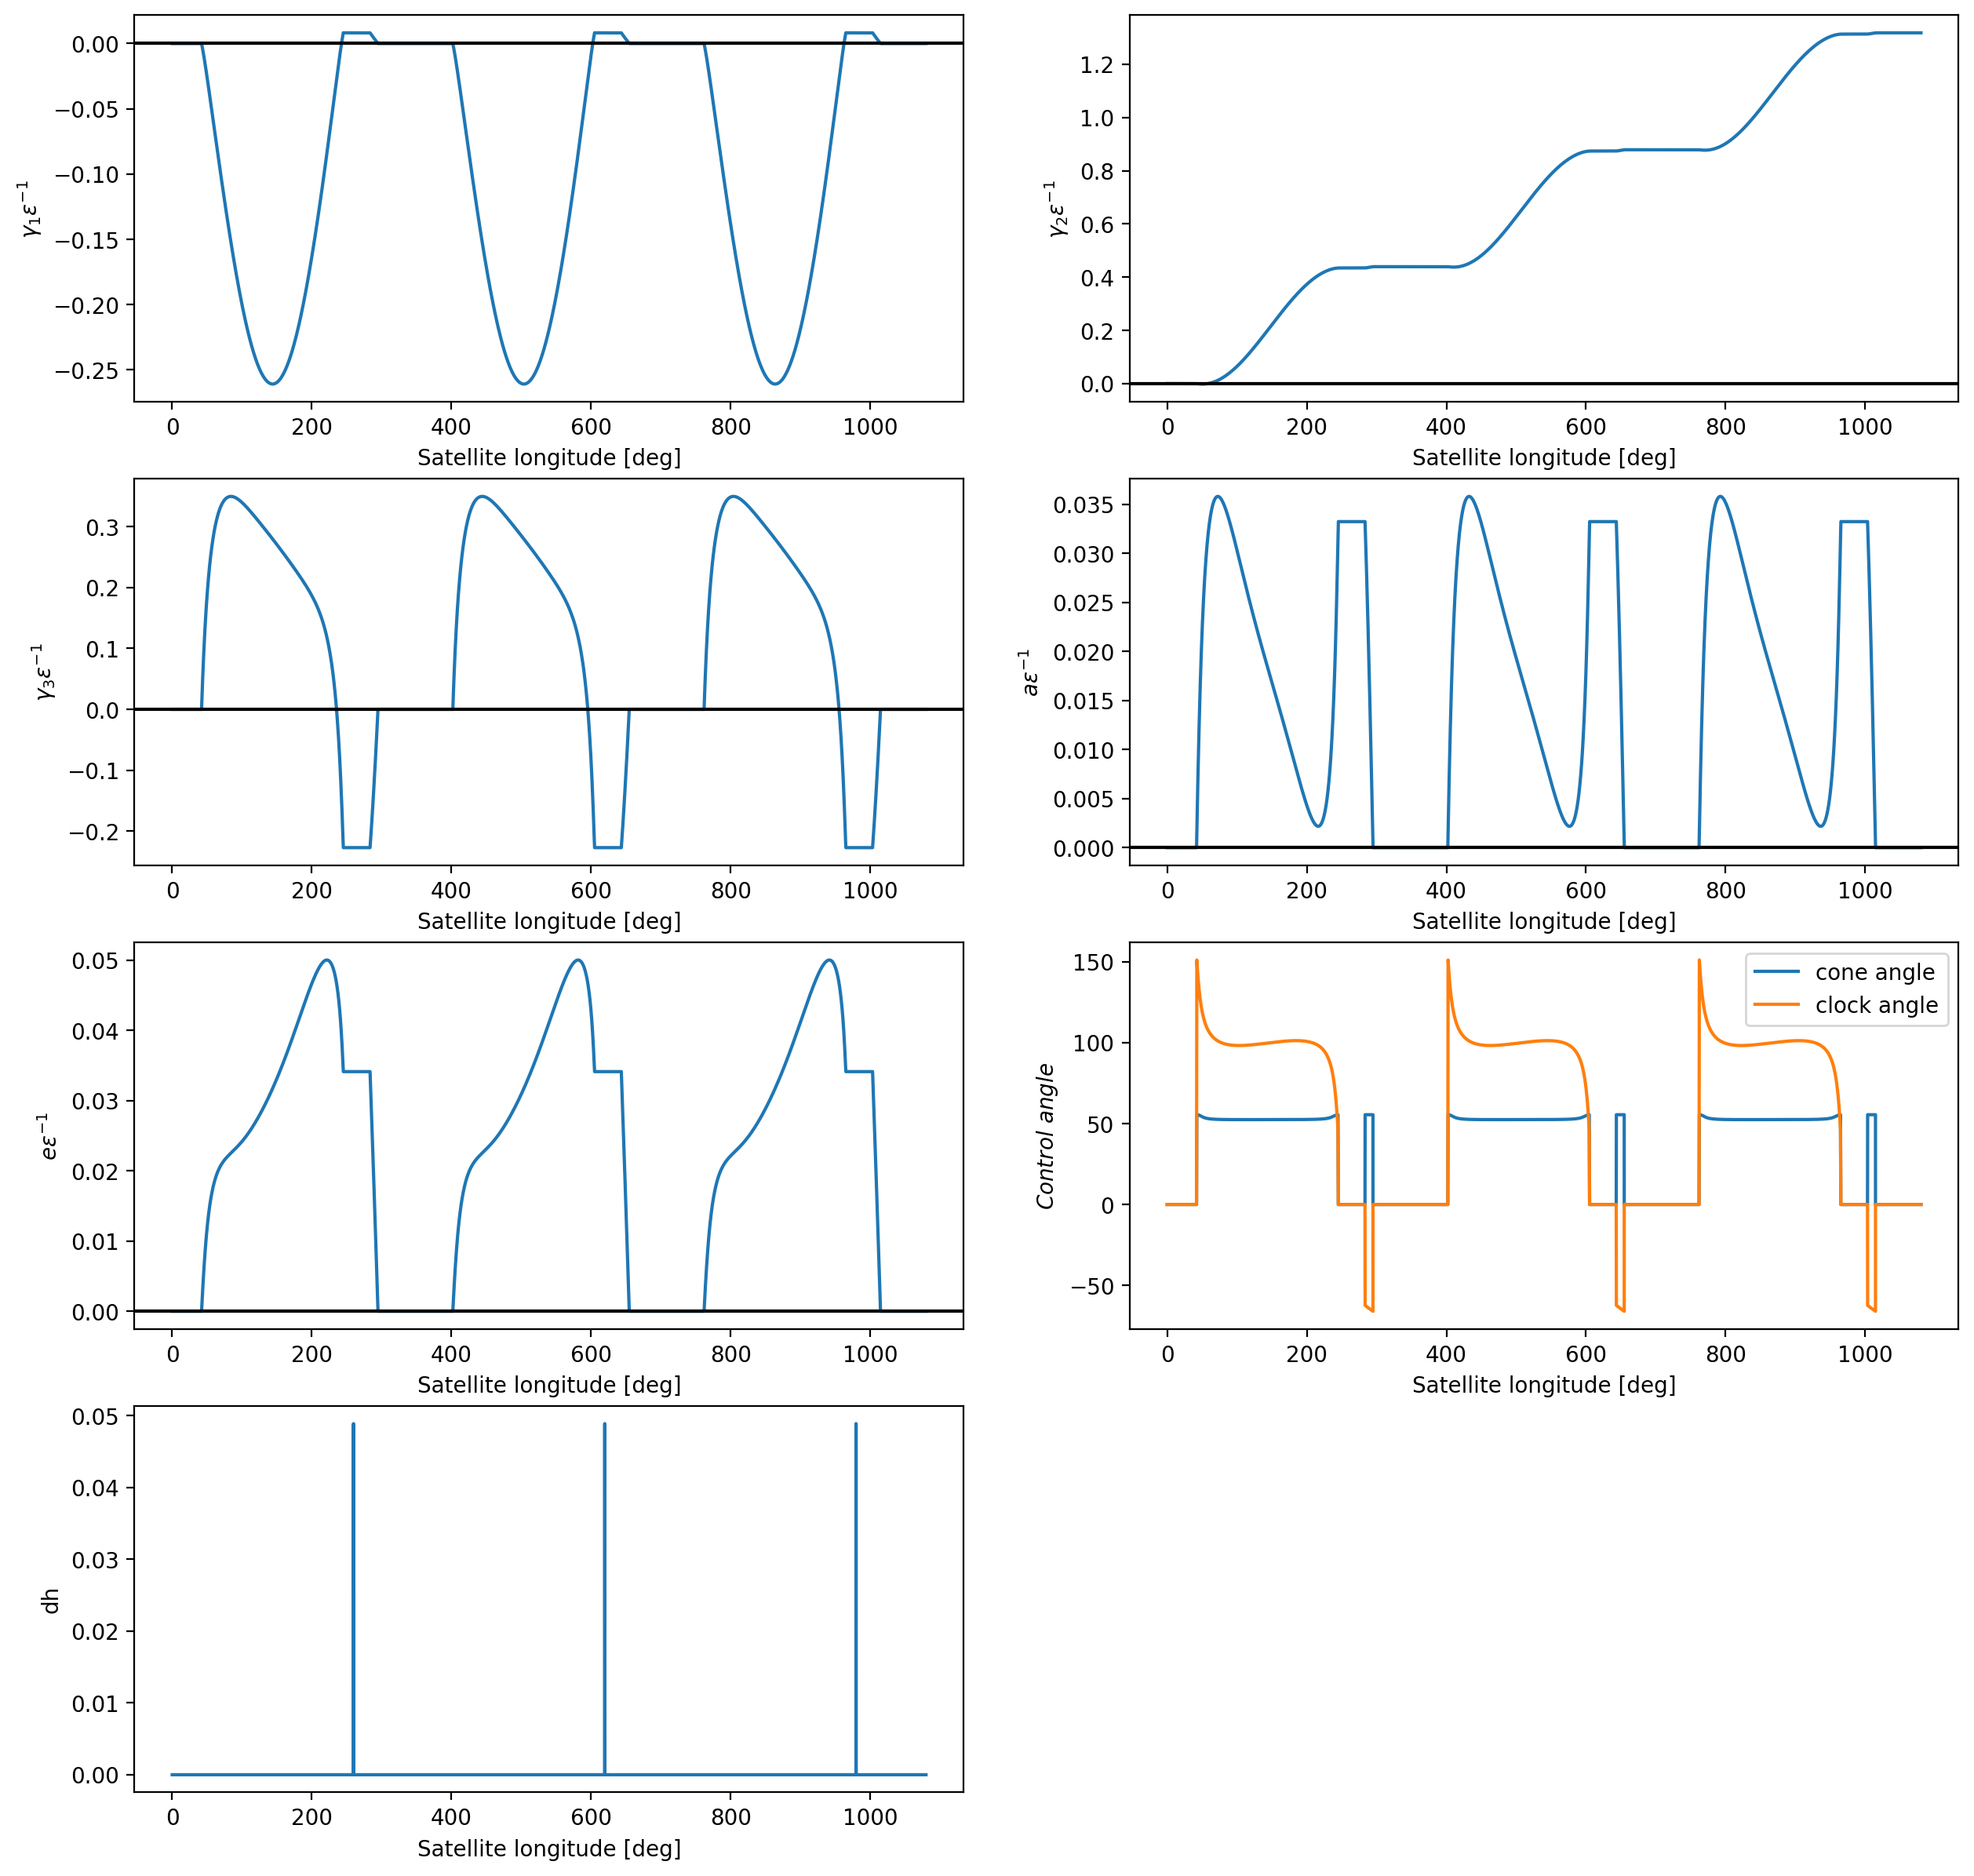

In [71]:
plotSolutionBSB(pdeltaI, M, sDir, sol.parsf, 3)

## Animated gif 

NameError: name 'allfirstsols' is not defined

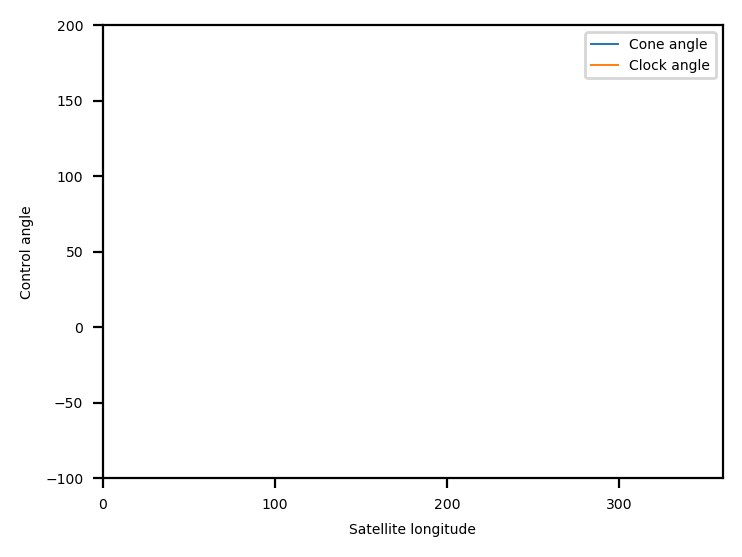

In [72]:
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#Initialization of the plot structure
fig = plt.figure(figsize=(4,3)); plt.tight_layout()
line, = plt.plot([], [], linewidth=0.7)
line2, = plt.plot([], [], linewidth=0.7)
plt.xlim(0, 360)
plt.ylim(-100, 200)
plt.xlabel("Satellite longitude", fontsize=5)
plt.ylabel("Control angle", fontsize=5)
plt.legend(["Cone angle","Clock angle"], fontsize = 5)
for tickLabel in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tickLabel.set_fontsize(5)

#Function that animate the gif
def animate(j) :
    M = np.array([])
    if(j < len(allfirstsols)) :
        pdeltaI         = allfirstsols[j][0 : 5]
        size = np.size(allfirstsols[j]) % 5
        M = np.hstack((M, M0))
        for i in range(0, size) :
            M = np.hstack((M, allfirstsols[j][i+5]))
        M = np.hstack((M, Mf))
        [M_vect, ang1, ang2] = plotControl(pdeltaI, M, sDir, firstpars[j], 1)
    else :
        j = j - len(allfirstsols)
        pdeltaI         = allfinalsols[j][0 : 5]
        size = np.size(allfinalsols[j]) % 5
        M = np.hstack((M, M0))
        for i in range(0, size) :
            M = np.hstack((M, allfinalsols[j][i+5]))
        M = np.hstack((M, Mf))
        [M_vect, ang1, ang2] = plotControl(pdeltaI, M, sDir, finalpars[j], 1)
        
    line.set_data(M_vect, ang1)
    line2.set_data(M_vect, ang2)
    return line, line2

#Function that plot the control only
def plotControl(pdeltaI, M, sDir, cont, nOrb):

    N       = 500
    size    = np.size(M) - 2 
    
    M_vect  = np.array([])
    M0_2_Mf = np.array([])
    I       = np.array([0., 0., 0., 0., 0]) 
    M0      = M[0]
    
    for i in range(0, size + 1) :
        M0_2_Mf = np.hstack((M0_2_Mf, np.linspace(M[i], M[i+1], N+1)))
    
    u_vect  = np.array([0., 0., 0.])
        
    for ii in range(nOrb):
        
        Mspan   = []
        
        for i in range(0, size + 1) : 
            Mspan.append(list((ii)*2*np.pi*np.ones(N+1)+M0_2_Mf[i*(N+1) : (i+1)*(N+1)]))
        
        for i in range(0,size + 1) :
            M_vect        = np.hstack((M_vect, Mspan[i]))
              
    u_vect = control(M_vect, I, pdeltaI, cont)
    u_s    = np.dot(u_vect,sDir)
    u_1    = u_vect[:,0]
    u_2    = u_vect[:,1]
    u_3    = u_vect[:,2]

    norm   = np.linalg.norm(u_vect,axis=1)
    ang1   = np.arccos(u_s/norm)
    where_are_NaNs = np.isnan(ang1)
    ang1[where_are_NaNs] = 0
    ang1   = rad2deg(ang1)
    
    ang2   = np.arctan2(u_2 / norm , u_1 / norm)
    where_are_NaNs = np.isnan(ang2)
    ang2[where_are_NaNs] = 0
    ang2   = rad2deg(ang2)

    M_vect = M_vect / 2 / np.pi * 360
    
    return M_vect, ang1, ang2
    
ani = animation.FuncAnimation(fig, animate, frames=len(allfirstsols)+len(sol.xout), interval=100)

video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

plt.close()

#### 